# Model

In this script we are trying to build the model to validate our idea. 
We will take the data from the bulk analysis as training data, and generate a matrix with fake proportion of cells just to train the model. 
For the final script model the bulk data can then be easily replaced with single-cell data, and at the bottom of the script  we just need to add the bulk data to predict the proportion of cells.

In Google Colab set the runtine as: ==R with TPU==; running it without TPU resulted in errors (possibly solved with "reticulate" package, code commented).

File(s) needed: 
    - 'bulk_tissue_data.csv' from notebook `01scripts\01_compBiology_bulk.ipynb`

## load libraries and functions

In [1]:
# libraries ####
#devtools::install_github("rstudio/keras")
#install.packages("tidyverse")
# install.packages("gradDescent")
library(keras)
library(tidyverse)
#library(gradDescent)

## custom functions ####
# create a function to generate mock data about the proportion of each cell type. For this the sum of the is 1
# with this function with can specify the mock number of cell type by the `n_rows` and the number of samples as `n_cols`

create_matrix <- function(n_rows, n_cols) {
  # Generate a vector of random numbers between 0 and 1
  data <- runif(n_rows * n_cols)

  # Create a matrix from the vector
  matrix <- matrix(data, nrow = n_rows, ncol = n_cols)

# Normalize the matrix such that the sum of each column is 1
  for (i in 1:n_cols) {
    matrix[, i] <- matrix[, i] / sum(matrix[, i])
  }

  return(matrix)
}

# as alternative scaling function --- NOT USED
min_max_scaling <- function(x) {
  return ((x - min(x)) / (max(x) - min(x)))
}

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.0.8     v readr     2.1.2
v forcats   1.0.0     v stringr   1.4.0
v ggplot2   3.3.5     v tibble    3.1.6
v lubridate 1.8.0     v tidyr     1.2.0
v purrr     0.3.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the [conflicted package](http://conflicted.r-lib.org/) to force all conflicts to become errors


## load data

In the `csv` data the first column (features) has the genes and other features such as `age` and `condition`. However, we did not changed the column name `ensembl_gene_id`.
To scale the data (standardization)  so that we can use data from bulk and single-cell RNA-seq, we need to split this data between what are genes and what is not, because we just want to scale the genes. The other variables are already numeric or need to be converted to  binary.

In [2]:
# load data ####
tissue_bulk_data <- read.csv("bulk_tissue_data.csv")
data <- tissue_bulk_data #[c(1:5,c(17276:17279)),1:5]
tail(data)
## preprocess data  ####
split_gene_features <- data[c(1:17275),-1]
tail(split_gene_features)


,ensembl_gene_id,GSM86787,GSM86788,GSM86789,GSM86790,GSM86791,GSM86792,GSM86793,GSM86794,GSM86795,...,GSM87114,GSM87115,GSM87116,GSM87117,GSM87118,GSM87119,GSM87120,GSM87121,GSM87122,GSM87123
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
17275,ENSG00000264063,6801.531514,4429.659722,4950.165634,7072.423633,4616.411884,3878.322864,5081.994179,3926.688791,4270.569187,...,2185.985749,2178.894532,2783.373021,1416.173419,372.393646,2189.782862,1765.817222,1997.441205,3318.636699,2061.247972
17276,condition,control,HD,control,HD,control,HD,control,HD,control,...,HD,HD,HD,HD,HD,HD,HD,HD,HD,HD
17277,condition_specified,control,grade 2,control,grade 3,control,grade 1,control,grade 1,control,...,grade 1,grade 2,grade 0,grade 2,grade 2,grade 1,grade 2,grade 1,grade 2,grade 1
17278,age,37,70,68,40,29,64,75,69,22,...,65,50,70,63,47,42,45,70,74,46
17279,sex,M,M,M,M,M,M,M,F,M,...,F,F,F,F,M,F,F,F,M,M
17280,source_name_ch1,Caudate Nucleus,Caudate Nucleus,Caudate Nucleus,Caudate Nucleus,Caudate Nucleus,Caudate Nucleus,Caudate Nucleus,Caudate Nucleus,Caudate Nucleus,...,Cerebellum,Cerebellum,Cerebellum,Cerebellum,Cerebellum,Cerebellum,Cerebellum,Cerebellum,Cerebellum,Cerebellum


,GSM86787,GSM86788,GSM86789,GSM86790,GSM86791,GSM86792,GSM86793,GSM86794,GSM86795,GSM86796,...,GSM87114,GSM87115,GSM87116,GSM87117,GSM87118,GSM87119,GSM87120,GSM87121,GSM87122,GSM87123
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
17270,73.23098667,70.00282978,41.93462495,50.47247914,90.64499841,84.42791171,87.93908801,57.341825,79.13125544,87.63215951,...,54.84021668,50.31019093,60.60705628,35.73655426,22.10625279,53.49701417,45.95614776,33.97938998,33.72024407,45.23983768
17271,39.62703851,74.62911586,53.4715984,44.14020841,64.60657731,67.70037423,42.75552271,48.22713889,53.27242302,51.31385409,...,91.46808451,80.52591083,69.95286219,104.2188227,105.9514732,93.36954174,55.80523852,51.18739671,72.52164861,86.98749683
17272,6801.531514,4429.659722,4950.165634,7072.423633,4616.411884,3878.322864,5081.994179,3926.688791,4270.569187,6969.30296,...,2185.985749,2178.894532,2783.373021,1416.173419,372.393646,2189.782862,1765.817222,1997.441205,3318.636699,2061.247972
17273,6801.531514,4429.659722,4950.165634,7072.423633,4616.411884,3878.322864,5081.994179,3926.688791,4270.569187,6969.30296,...,2185.985749,2178.894532,2783.373021,1416.173419,372.393646,2189.782862,1765.817222,1997.441205,3318.636699,2061.247972
17274,6801.531514,4429.659722,4950.165634,7072.423633,4616.411884,3878.322864,5081.994179,3926.688791,4270.569187,6969.30296,...,2185.985749,2178.894532,2783.373021,1416.173419,372.393646,2189.782862,1765.817222,1997.441205,3318.636699,2061.247972
17275,6801.531514,4429.659722,4950.165634,7072.423633,4616.411884,3878.322864,5081.994179,3926.688791,4270.569187,6969.30296,...,2185.985749,2178.894532,2783.373021,1416.173419,372.393646,2189.782862,1765.817222,1997.441205,3318.636699,2061.247972


From this table (above) we can see that we have exported more features that what we need to be able to use the two data sets. For example,"condition_specified" is not present in single-cell-RNAseq data. Also, the sex M/F, so we need to convert to 0/1. Therefore, this is information that we can ignore in this script.

In [4]:
### convert to binary
binary_sex <- ifelse(data[17279,-1 ] == "F", 1, 0)
binary_condition <- ifelse(data[17276,-1 ] == "control", 0, 1)
binary_sex

,GSM86787,GSM86788,GSM86789,GSM86790,GSM86791,GSM86792,GSM86793,GSM86794,GSM86795,GSM86796,...,GSM87114,GSM87115,GSM87116,GSM87117,GSM87118,GSM87119,GSM87120,GSM87121,GSM87122,GSM87123
17279,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,0,1,1,1,0,0


Now with the split feature genes from other phenoData we can scale the genes using the function `scale()`. We decided to use this standard function, but it is something that we can research and possibbly find better option for this  kind of genomic data. 

In [5]:
scale_genes <- t(scale(t(data.matrix(split_gene_features))))
head(scale_genes)
# merge scale genes with other feature (sex and condition)
x_original <- rbind(scale_genes,binary_sex,binary_condition)

,GSM86787,GSM86788,GSM86789,GSM86790,GSM86791,GSM86792,GSM86793,GSM86794,GSM86795,GSM86796,...,GSM87114,GSM87115,GSM87116,GSM87117,GSM87118,GSM87119,GSM87120,GSM87121,GSM87122,GSM87123
1,-0.5870559,0.3771656,-0.9221756,-1.6185020,0.11629402,0.2778337,-0.26196978,-0.55093523,-0.07534626,0.1965622,...,-0.3151475,-0.94525267,-0.5629755,0.08519010,0.5868662,0.08318339,-0.4305330,0.5898763,-0.5158179,0.20960578
2,-0.2882194,0.5739242,-0.1415822,-0.2923793,-0.83212900,0.5250451,0.22969074,-0.27781957,-0.12078257,-0.8331690,...,1.3934285,0.56144441,1.4038283,1.08455443,0.6935219,0.41376723,1.2031122,1.8478999,1.6908629,1.65342357
3,-0.3982440,0.6170205,-0.6919505,0.2061137,-0.36153065,-0.1836123,0.24565116,-0.17231585,-0.49355739,0.2498873,...,0.4263937,-0.05793974,0.1348052,0.04655201,0.2456512,-0.12713023,-0.2245617,0.5824253,-0.0650000,-0.36011860
4,0.7291401,3.0609584,0.6708589,-0.7473163,0.04119366,1.6759234,0.76799417,0.06633456,-0.45076800,0.3628829,...,-0.8318812,-1.84951616,0.1994670,-1.21013741,1.8319113,-0.57361557,-0.6033275,0.1314723,-0.1176511,-1.04957849
5,-0.1774781,0.1942992,0.1084580,-0.2421613,0.35933209,-0.4706683,0.52678301,-0.35460123,-0.04267101,-0.2367206,...,0.1840225,-1.38348736,-1.4584473,-0.01123618,0.3278973,0.18946311,0.1562147,-0.0196994,-0.9657668,0.51650624
6,0.9441752,2.7498092,1.0634738,0.5402997,0.45579657,-0.3668667,0.09914347,0.71427687,-0.95714622,-1.0130674,...,1.0224649,-0.67256935,0.2159567,1.81281815,1.2536060,-0.17176377,-1.1733749,1.7519262,1.3927877,-0.05743594


Now let's just print the original data to check that the `scale()` worked.

In [6]:
tail(x_original)

,GSM86787,GSM86788,GSM86789,GSM86790,GSM86791,GSM86792,GSM86793,GSM86794,GSM86795,GSM86796,...,GSM87114,GSM87115,GSM87116,GSM87117,GSM87118,GSM87119,GSM87120,GSM87121,GSM87122,GSM87123
17272,1.413074,0.3372961,0.5258924,1.520349,0.3792544,-0.05460377,0.8226289,-0.02302685,0.2447281,1.550628,...,-1.352285,-1.357476,-0.8487849,-2.369235,0.0574294,-1.40722,-1.989014,-1.664594,-0.3573961,-1.484649
17273,1.413074,0.3372961,0.5258924,1.520349,0.3792544,-0.05460377,0.8226289,-0.02302685,0.2447281,1.550628,...,-1.352285,-1.357476,-0.8487849,-2.369235,0.0574294,-1.40722,-1.989014,-1.664594,-0.3573961,-1.484649
17274,1.413074,0.3372961,0.5258924,1.520349,0.3792544,-0.05460377,0.8226289,-0.02302685,0.2447281,1.550628,...,-1.352285,-1.357476,-0.8487849,-2.369235,0.0574294,-1.40722,-1.989014,-1.664594,-0.3573961,-1.484649
17275,1.413074,0.3372961,0.5258924,1.520349,0.3792544,-0.05460377,0.8226289,-0.02302685,0.2447281,1.550628,...,-1.352285,-1.357476,-0.8487849,-2.369235,0.0574294,-1.40722,-1.989014,-1.664594,-0.3573961,-1.484649
17279,0.000000,0.0000000,0.0000000,0.000000,0.0000000,0.00000000,0.0000000,1.00000000,0.0000000,0.000000,...,1.000000,1.000000,1.0000000,1.000000,0.0000000,1.00000,1.000000,1.000000,0.0000000,0.000000
17276,0.000000,1.0000000,0.0000000,1.000000,0.0000000,1.00000000,0.0000000,1.00000000,0.0000000,0.000000,...,1.000000,1.000000,1.0000000,1.000000,1.0000000,1.00000,1.000000,1.000000,1.0000000,1.000000


It worked. Now we have our `x` data ready to build our model, but since we don't have the proportion of the cell type for the bulk data we will generate mock that with the function define above. 
For sake of simplicity we will only consider 4 cell types, and, naturally, the number of samples must the same (aka the number of patient samples).

In [7]:
# Create a mock matrix for cell type porportion with random numbers
number_of_cell_types = 4
number_of_samples = dim(x_original)[2] # number of patients
y_original <- create_matrix(number_of_cell_types,number_of_samples)

# Normalize the columns to sum to 1
y_original <- y_original / colSums(y_original)

In [1]:
y_original

ERROR: Error in eval(expr, envir, enclos): object 'y_original' not found


# Build model

Ok, now we have our data ready to build the model. For that we will used keras package, and as starting point we will consider that the number of features to be equal to number of genes; this might need to be optimized. 
But, before we proceed, let's just check that the matrices size are correct.

In [9]:
# build the model ####
## define feature and targets 
x <- x_original
y <- y_original
# check matrix dims
tissue_composition <- dim(y)[1]
number_of_features <- dim(x)[1]
dim(x)
dim(y)
tissue_composition

[1] 17277   201

[1]   4 201

[1] 4

We can now see the the matrix is has the samples in rows, so we need to transpose the matrix to build the model; features should be the columns and rows the observation (patient samles).
At this stage we also need to split that data into "training" and "testing"; we will consider arbitrary proportion of  $0.8$ for training and $0.2$ for testing.

In [10]:
# Assuming you have a dataset 'data' with features 'x' and labels 'y'
x <- t(x)
y <- t(y)
# Set a random seed for reproducibility
set.seed(123)

# Define the proportion of data to use for testing (e.g., 20%)
test_split_ratio <- 0.2

# Generate random indices for splitting the data
num_samples <- nrow(x)
num_test_samples <- round(num_samples * test_split_ratio)
test_indices <- sample(1:num_samples, num_test_samples)

# Split the data into training and test sets
x_train <- x[-test_indices, ]  # Training features
y_train <- y[-test_indices, ]  # Training labels
x_test <- x[test_indices, ]    # Test features
y_test <- y[test_indices, ]    # Test labels

In [21]:
# Initialize model
# reticulate::use_condaenv("base", conda = "auto") # run on cpu
model <- keras_model_sequential()


In [25]:
# Add layers
feature_factor = 1
model %>%
  layer_dense(units = feature_factor*number_of_features, activation = 'sigmoid', input_shape = dim(x)[2]) %>% # units=265 relu
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 128, activation = 'sigmoid') %>% #units = 128 relu
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = tissue_composition, activation = 'softmax')


In [26]:
# Compile model
model %>% compile(
  loss = 'categorical_crossentropy', # binary_crossentropy #
  optimizer = optimizer_rmsprop(),#optimizer_rmsprop(),
  metrics = c('accuracy')
)

In [27]:
# Train model
history <- model %>% fit(
  x_train,
  y_train,
  epochs = 100, #30
  batch_size = 32, # 32
  #validation_split = 0.2
)

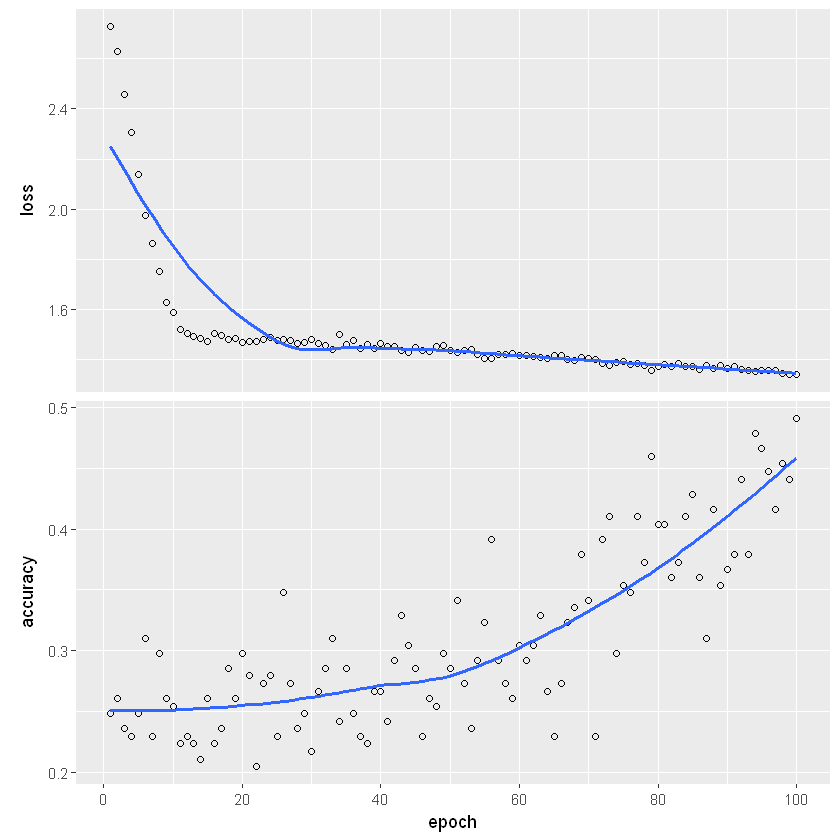

In [28]:
plot(history)

In [29]:
# Evaluate model
model %>% evaluate(x_test, y_test)

# Make predictions
predictions <- model %>% predict(x_test) %>% k_argmax()

loss accuracy 
1.420964 0.175000

The code seems to be running without errors. We can see that the accuracy is not great, but this is expected since we used random data to train the model.  
Now we just want to check that the results for the predictions have a sum closer to 1. If the sum is not 1 it might indicate that the last function is not properly applied. 

In [ ]:
predictions = model %>% predict(x_train)
head(predictions)
head(model %>% predict(x_train)) %>% apply(1, sum)

Good, the sum is closer to one. Now let's just check how different are the values predict form the training values (yet knowing that the accuracy is not great).

In [ ]:
head(y_train)
head(y_train %>% apply(1, sum))

Ok, great that is it! The code for the model is running.

# Prepare bulk data to be used by model trained with single-cell-RNAseq data

The steps here are identical to what was performed before, but have some adjustments like cheking that the genes between datasets are the same and in the same order in the table. 
We decided to do this step because in the first layer the number of features is the same as the number of feature, therefore we thought that their order could have implications. Thus, to avoid adding unnecessary variables we made sure that the features are equally ordered (aka have the same index).

In [2]:
# process and prepare bulk for pipeline
data_bulk <- read.csv("bulk_tissue_data.csv")
genes_in_singleCell <- tissue_bulk_data$ensembl_gene_id[c(11,5,9,8)]
genes_filter_bulk <- data_bulk %>% filter(ensembl_gene_id %in% genes_in_singleCell)
matched_gene_order_bulk <- genes_filter_bulk %>% arrange(match(ensembl_gene_id,genes_in_singleCell))
# remove ensembl
split_gene_features <- matched_gene_order_bulk[,-1]
### convert to binary
binary_sex <- ifelse(data_bulk[17276,] == "F", 1, 0)[,-1]
binary_condition <- ifelse( data_bulk[17279,] == "control", 0, 1)[,-1]
# scale
scale_genes <- t(scale(t(data.matrix(split_gene_features))))
head(scale_genes)
head(binary_sex)
head(binary_condition)
bulk_genes_filtered <- rbind(scale_genes,binary_sex,binary_condition)
bulk_genes_filtered

ERROR: Error in eval(expr, envir, enclos): object 'tissue_bulk_data' not found
